# Smoothing bequests distribution by multivariate kernel density estimator
### [Richard W. Evans](https://sites.google.com/site/rickecon/), February 2018
The code in this Jupyter notebook was written using Python 3.6. It uses data file `BQ_mat_raw_ITA.csv`. For the code to run properly, you should have the data file in the same folder as this Jupyter notebook file.

## 1. Read in the data and do some cleaning
We first read in the data as a `NumPy` array. The object should come in as a $7\times 51$ matrix in which each row corresponds to one of the seven income categories, and each column corresponds to ages 30 through 80, respectively. The respective income percentiles represented by the seven income categories are:

$$ \lambda = [0.25, \:0.25, \:0.20, \:0.10, \:0.10, \:0.09, \:0.01] $$

We want the source data to be transposed so that it is $51\times 7$, and we want to make sure that the sum of all the cells equals 1.0.

In [37]:
# Import all the stuff I need
import numpy as np
from scipy.stats import kde

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# This next command is specifically for Jupyter Notebook
%matplotlib notebook

In [30]:
# Import the rough bequest distribution matrix and transpose it
BQ_mat_raw = np.loadtxt('BQ_mat_raw_ITA.txt', delimiter=',').T

In [31]:
# Some diagnostics
print('Shape of BQ_mat_raw', BQ_mat_raw.shape)
print('Bequest distribution by income group:',
      BQ_mat_raw.sum(axis=0))
print('Sum of all probabilities', BQ_mat_raw.sum())

Shape of BQ_mat_raw (51, 7)
Bequest distribution by income group: [ 0.          0.          0.00149992  0.03048317  0.1224768   0.68240364
  0.16313647]
Sum of all probabilities 0.99999999483


In [32]:
# Because the sum of all probabilities is not exactly equal
# to 1.0, I rescale the matrix.
BQ_mat_raw = BQ_mat_raw / BQ_mat_raw.sum()
print(BQ_mat_raw.sum())

1.0


Now let's plot the raw matrix to see what it looks like.

<IPython.core.display.Javascript object>


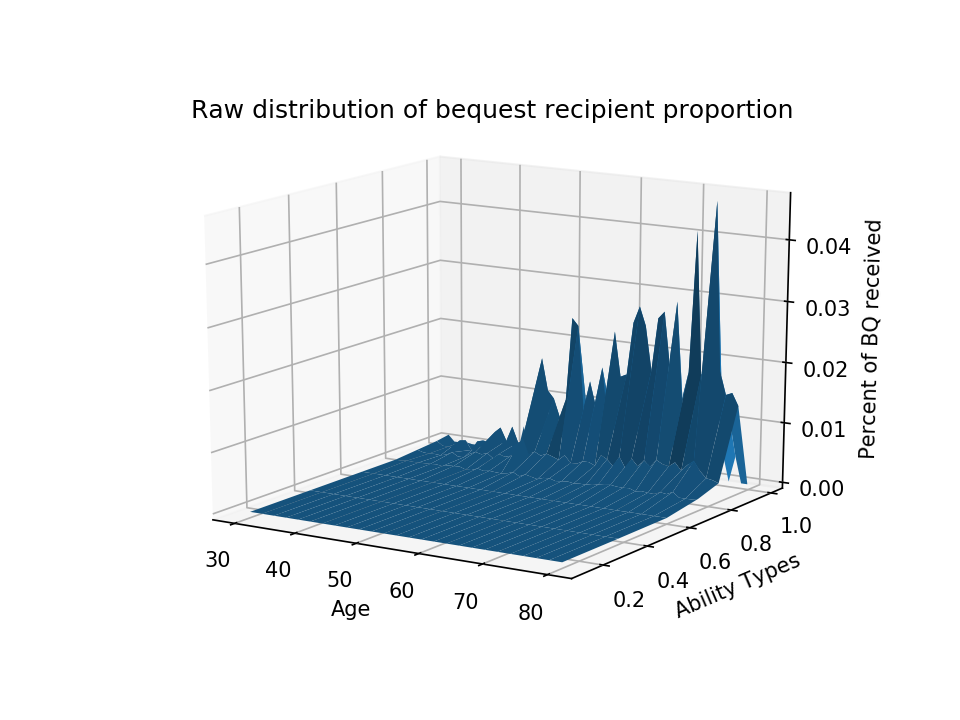

In [63]:
# Make 3D surface plot of rough bequests distribution matrix
age_vec = np.arange(30, 81)
lambdas = np.array([0.25, 0.25, 0.20, 0.10, 0.10, 0.09, 0.01])
lambdas_mdpts = np.array([0.125, 0.375, 0.60, 0.75, 0.85,
                          0.94, 0.995])
income_mat, age_mat = np.meshgrid(lambdas_mdpts, age_vec)

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(age_mat, income_mat, BQ_mat_raw)
ax.set_title('Raw distribution of bequest recipient proportion')
ax.set_xlabel('Age')
ax.set_ylabel('Ability Types')
ax.set_zlabel('Percent of BQ received')

## 2. Smooth the surface with MVKDE()
In looking at the raw bequests distribution matrix in the Figure above, the bequests recipient percentages are pretty spikey for the last three lifetime income groups. This is likely noise from the small survey sample. Now that we have the raw version of the bequests distribution matrix cleaned up, we can use the `MVKDE()` function to create a smoothed version.

In [41]:
def MVKDE(S, J ,proportion_matrix=None, filename=None,
          plot=False, bandwidth=0.25):
    '''
    Generates a Multivariate Kernel Density Estimator and returns a matrix
    representing a probability distribution according to given age categories,
    and ability type categories.

    INPUTS:
    S                  = scalar, the number of age groups in the model.
    J                  = scalar, the number of ability type groups in the model.

     proportion_matrix = [S, J], array containing the proportion matrix
                         created by SCFExtract.py. This argument would
                         be used if you are passing in the
                         proportion_matrix directly
    filename           = string, the file name of the .txt document that
                         contains the original proportion matrix created
                         by SCFExtract.py. Use this argument if you have
                         saved the proportion matrix in a .txt file

        plot                  = boolean, whether or not you want a plot of the probability
                                distribution generated by your given age and ability type
                                groups.

        bandwidth             = scalar, used in the smoothing of the kernel. Higher bandwidth
                                creates a smoother kernel.

    Functions called:
        kde.gaussian_kde      = scipy function that generates a Kernel
                                Density Estimator from given data

    Objects in function:
        proportion_matrix     = [78, 7], array containing the proportion (0 < x < 1) of
                                the total bequests that each age-income category receives.
                                Derived in SCFExtract.py

        age_probs             = [78,], array containing the frequency, or how many times,
                                that random drawn numbers fell into the 78 different age bins

        income_probs          = [7,], array containing the frequency, or how many times,
                                that random drawn numbers fell into the 7 different ability
                                type bins

        age_frequency         = [70000,], array containing repeated age values for each
                                age number at the frequency given by the age_probs vector

        xmesh                 = complex number, the number of age values that will be
                                evaluated in the Kernel Density Estimator.

        freq_mat              = [70000, 2], array containing age_frequency and
                                income_frequency stacked

        density               = object, class given by scipy.stats.gaussian_kde.
                                The Multivariate Kernel Density Estimator for the given data set.

        age_min, age_max      = scalars, the minimum and maximum age values and minimum
        income_min, income_max  and maximum income values


        agei                  = [S, J], array containing the age values to be evaluated in
                                the Kernel Estimator (ranging from 18-90)

        incomei               = [S, J], array containing the income values to be evaluated
                                in the Kernel Estimator (ranging from 1-7)

        coords                = [2, S*J], array containing the raveled values of agei
                                and incomei stacked

        estimator             = [S, J], array containing the new proportion values for
                                s age groups and e ability type groups that are evaluated
                                using the Multivariate Kernel Density Estimator

        estimator_scaled       = [S, J], array containing the new proportion values for
                                s age groups and e ability type groups that are evaluated using
                                the Multivariate Kernel Density Estimator, but scaled so that
                                the sum of the array is equal to one.

    Returns: estimator_scaled
    '''
    if proportion_matrix is None:
        proportion_matrix = np.loadtxt(filename, delimiter = ',')
    proportion_matrix_income = np.sum(proportion_matrix, axis = 0)
    proportion_matrix_age = np.sum(proportion_matrix, axis = 1)
    age_probs = np.random.multinomial(70000,proportion_matrix_age)
    income_probs = np.random.multinomial(70000, proportion_matrix_income)
    age_frequency = np.array([])
    income_frequency = np.array([])
    age_mesh = complex(str(S)+'j')
    income_mesh = complex(str(J)+'j')

    j = 18
    '''creating a distribution of age values'''
    for i in age_probs:
        listit = np.ones(i)
        listit *= j
        age_frequency = np.append(age_frequency, listit)
        j+=1

    k = 1
    '''creating a distribution of ability type values'''
    for i in income_probs:
        listit2 = np.ones(i)
        listit2 *= k
        income_frequency = np.append(income_frequency, listit2)
        k+=1

    freq_mat = np.vstack((age_frequency, income_frequency)).T
    density = kde.gaussian_kde(freq_mat.T, bw_method=bandwidth)
    age_min, income_min = freq_mat.min(axis=0)
    age_max, income_max = freq_mat.max(axis=0)
    agei, incomei = np.mgrid[age_min:age_max:age_mesh, income_min:income_max:income_mesh]
    coords = np.vstack([item.ravel() for item in [agei, incomei]])
    estimator = density(coords).reshape(agei.shape)
    estimator_scaled = estimator/float(np.sum(estimator))
    if plot == True:
        fig = plt.figure()
        ax = fig.gca(projection='3d')
        ax.plot_surface(agei,incomei, estimator_scaled, rstride=5)
        ax.set_xlabel("Age")
        ax.set_ylabel("Ability Types")
        ax.set_zlabel("Received proportion of total bequests")
        plt.show()
    return estimator_scaled

<IPython.core.display.Javascript object>


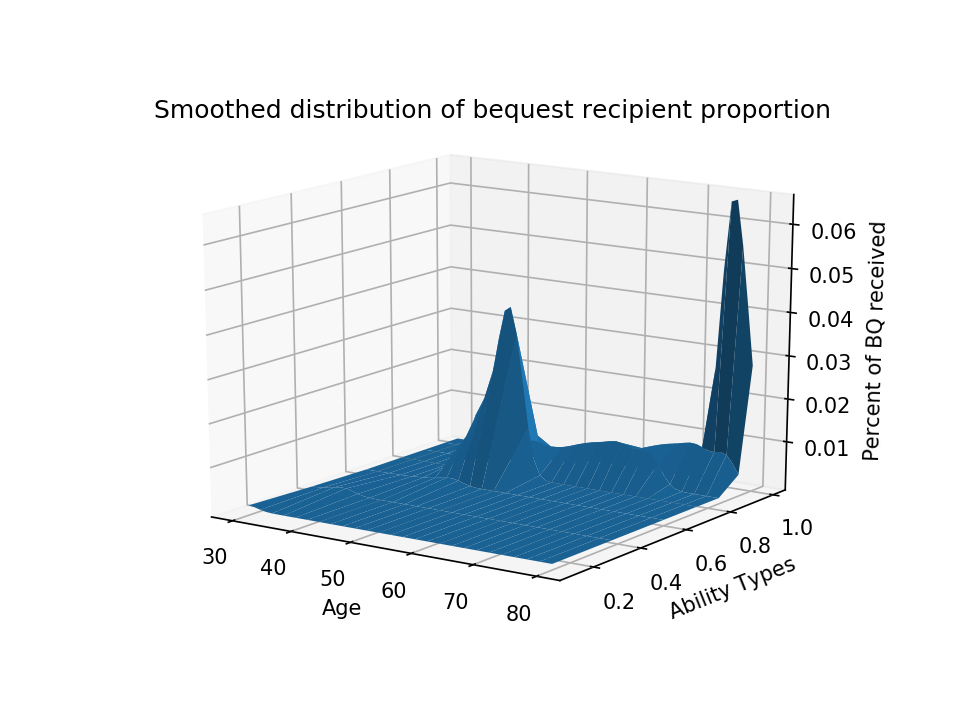

In [60]:
S, J = BQ_mat_raw.shape
BQ_mat_smth1 = MVKDE(S, J, BQ_mat_raw)

# Plot the smoothed bequests distribution
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(age_mat, income_mat, BQ_mat_smth1)
ax.set_title('Smoothed distribution of bequest recipient proportion')
ax.set_xlabel('Age')
ax.set_ylabel('Ability Types')
ax.set_zlabel('Percent of BQ received')

The smoothed bequest distribution in the figure above does not look enough like the data in the raw figure to be believable. We can adjust the smoothing parameter `bandwidth` in the `MVKDE()` function to see if we can get a better fit. Of all the differnent values I tried, I liked `bandwidth=0.95`. But you should experiment. This part is art. That is, there is no specific criterion that we are minimizing. This is an "eyeball" test.

<IPython.core.display.Javascript object>


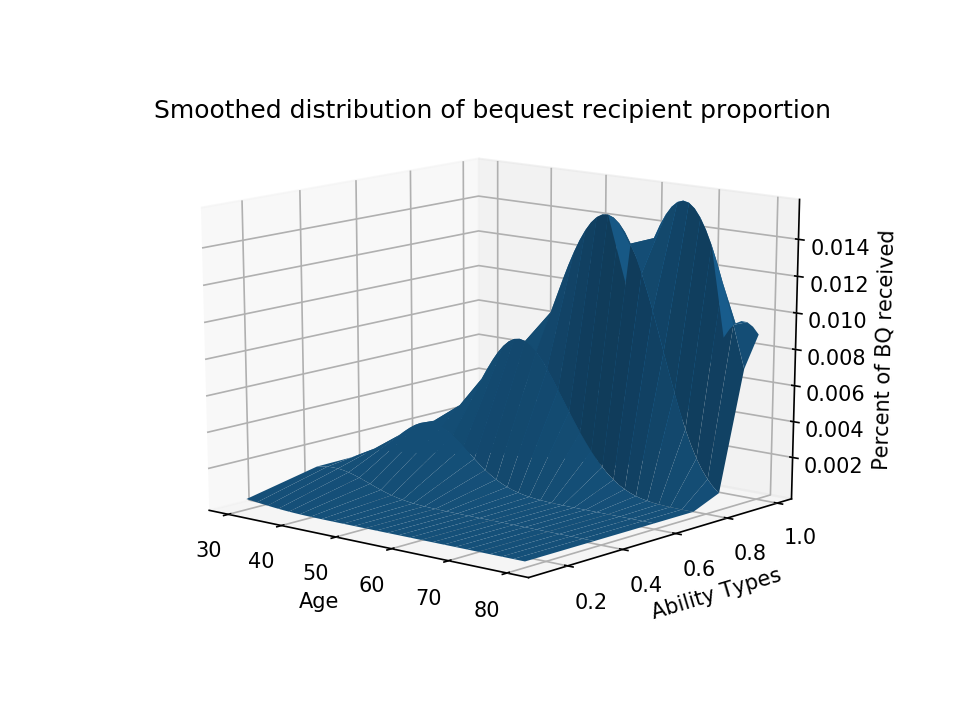

In [61]:
BQ_mat_smth2 = MVKDE(S, J, BQ_mat_raw, bandwidth=0.95)

# Plot the smoothed bequests distribution
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(age_mat, income_mat, BQ_mat_smth2)
ax.set_title('Smoothed distribution of bequest recipient proportion')
ax.set_xlabel('Age')
ax.set_ylabel('Ability Types')
ax.set_zlabel('Percent of BQ received')

Now just output the smoothed matrix as a comma-separated `.txt` file.

In [62]:
BQ_mat_smth = BQ_mat_smth2.copy()
np.savetxt('BQ_mat_smth_ITA.txt', BQ_mat_smth2, delimiter=',')